In [19]:
import h5py
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch
import torch.nn as nn

from PIL import Image
from torchvision import transforms
from sklearn.decomposition import PCA

rng = random.Random(42)

In [20]:
TELLU_PATH = 'data/tellu.h5'
ORGAQUANT_PATH = 'data/orgaquant.h5'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Visualize datasets

In [21]:
def load_and_show_example(img_index=0, data_path=TELLU_PATH):
    with h5py.File(data_path, 'r') as hdf:
        group = hdf['train']
        img_names = list(group['images'].keys())
        
        target_name = img_names[img_index]
        print(f"Chargement de l'image : {target_name}")

        img = np.array(group['images'][target_name])
        labels = np.array(group['labels'][target_name])

    # Plots
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap='gray')
    
    # Bounding Boxes
    for lbl in labels:
        # lbl = [class, x1, y1, x2, y2]
        if data_path == TELLU_PATH:
            x1, y1, x2, y2 = lbl[1], lbl[2], lbl[3], lbl[4]
        elif data_path == ORGAQUANT_PATH:
            x1, y1, x2, y2 = lbl[0], lbl[1], lbl[2], lbl[3]
        else:
            raise ValueError("Unknown data path")
        width = x2 - x1
        height = y2 - y1
        
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"Org", color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.title(f"Visualization : {target_name}")
    plt.axis('off')
    plt.show()

Example 81:
Chargement de l'image : Image171


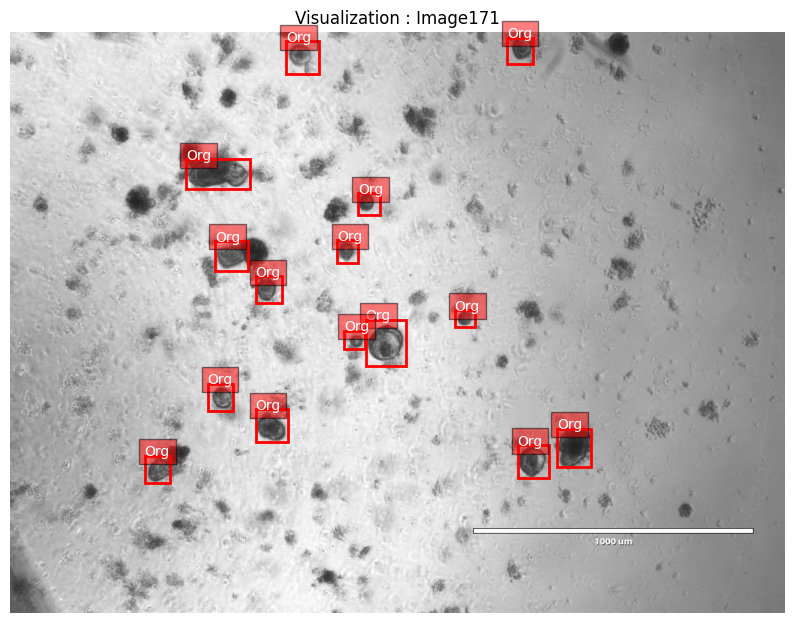

Example 14:
Chargement de l'image : Image110


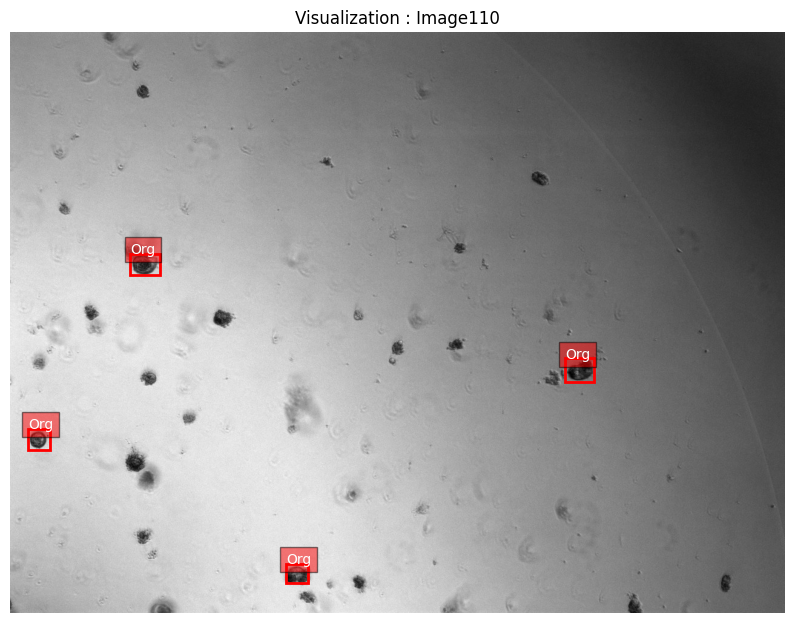

Example 3:
Chargement de l'image : Image100


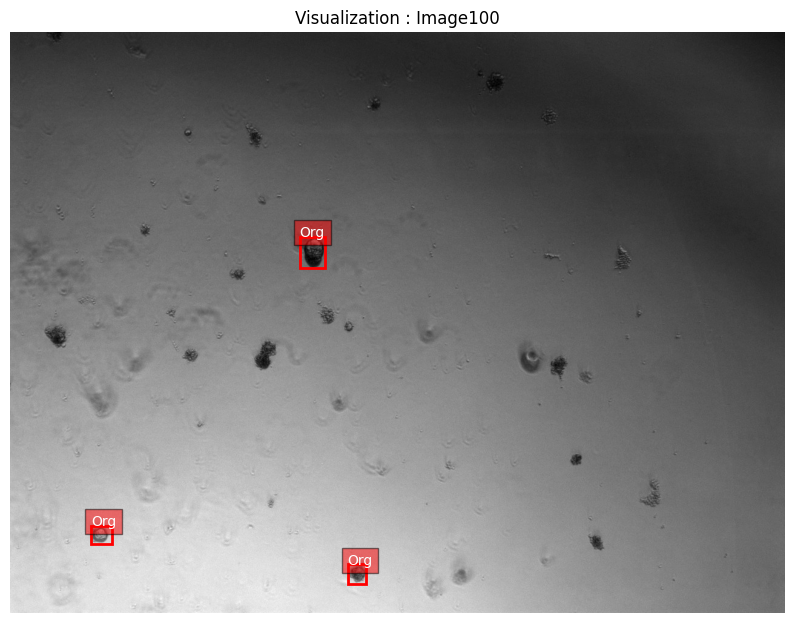

In [22]:
for i in rng.sample(range(100), 3):
    print(f"Example {i}:")
    load_and_show_example(i, TELLU_PATH)

Example 94:
Chargement de l'image : Subset_1_300x300_095


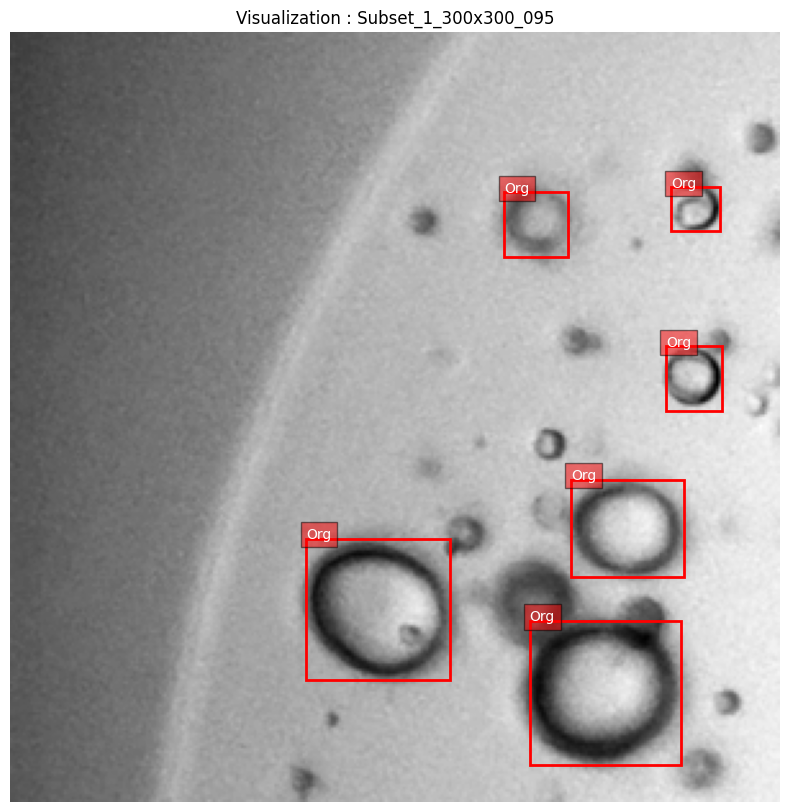

Example 35:
Chargement de l'image : Subset_1_300x300_036


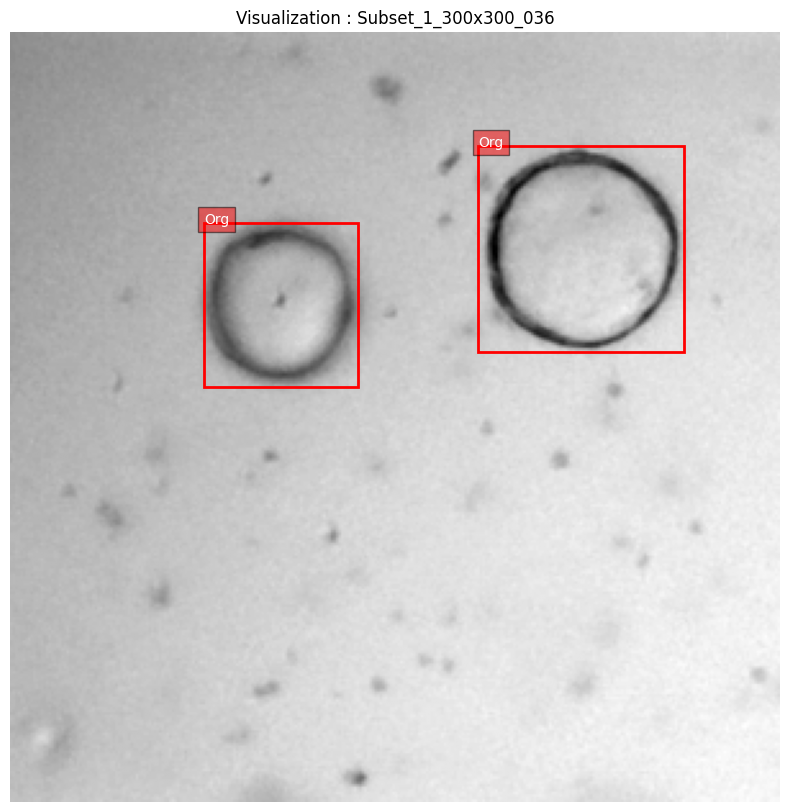

Example 31:
Chargement de l'image : Subset_1_300x300_032


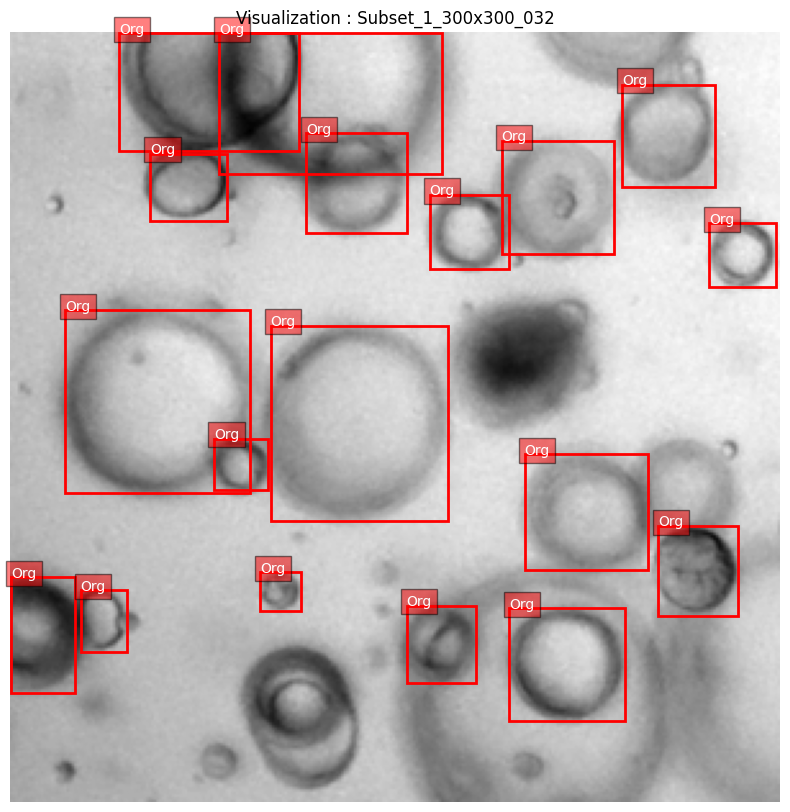

In [23]:
for i in rng.sample(range(100), 3):
    print(f"Example {i}:")
    load_and_show_example(i, ORGAQUANT_PATH)

## Attention Maps

Il faut modifier les fonctions à cause de la structure un peu différente de Curia, à terme on créera une unique fonction qui séparera les cas pour simplifier l'utilisation. Je laisse le code avec les commentaires bizarres du coup.

In [24]:
def interpolate_pos_encoding_curia(model, x, w, h):
    # Dans Curia, l'attribut est souvent model.embeddings.position_embeddings
    # La forme est généralement [1, N_patches + 1, Dim]
    pos_embed = model.embeddings.position_embeddings
    
    N = pos_embed.shape[1] - 1
    npatch = x.shape[1] - 1
    
    if npatch == N and w == h:
        return pos_embed

    class_pos_embed = pos_embed[:, 0]
    patch_pos_embed = pos_embed[:, 1:]
    dim = x.shape[-1]

    # Patch size est de 16 pour Curia selon ta structure Conv2d(1, 768, kernel_size=(16, 16))
    patch_size = 16
    target_h = h // patch_size
    target_w = w // patch_size

    # Calcul de la taille de la grille originale (généralement racine carrée de N)
    w0 = h0 = int(math.sqrt(N))
    
    patch_pos_embed = torch.nn.functional.interpolate(
        patch_pos_embed.reshape(1, w0, h0, dim).permute(0, 3, 1, 2),
        size=(target_h, target_w),
        mode='bicubic',
        align_corners=False,
    )
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

def get_attention_maps_curia(model, transform, img_size, img_index=0, block_index=11, h5_path=None, device='cuda'):
    model.to(device)
    model.eval()

    # 1. Chargement Image
    with h5py.File(h5_path, 'r') as hdf:
        img_raw = np.array(hdf['train']['images'][list(hdf['train']['images'].keys())[img_index]])
    img_pil = Image.fromarray(img_raw).convert('L')
    img_display = img_pil.convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # 2. Préparation du Hook
    # On cible la couche qui calcule l'attention
    target_layer = model.encoder.layer[block_index].attention.attention
    attention_probs = []

    def hook_fn(module, input, output):
        # Dans Curia, l'attention est souvent calculée manuellement
        # Si la couche ne renvoie pas l'attention, on la recalcule ici très vite
        hidden_states = input[0]
        q = module.query(hidden_states)
        k = module.key(hidden_states)
        
        B, N, C = q.shape
        num_heads = module.num_attention_heads
        head_dim = C // num_heads
        
        q = q.view(B, N, num_heads, head_dim).transpose(1, 2)
        k = k.view(B, N, num_heads, head_dim).transpose(1, 2)
        
        attn = (q @ k.transpose(-2, -1)) * (head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attention_probs.append(attn.detach().cpu())

    handle = target_layer.register_forward_hook(hook_fn)

    try:
        with torch.inference_mode():
            # Inférence complète (très rapide car native)
            model(img_tensor)
        
        if not attention_probs:
            print("Erreur : Le hook n'a pas capturé d'attention.")
            return

        attentions = attention_probs[0][0] # [Heads, Tokens, Tokens]
        nh = attentions.shape[0]
        side = 28 # Pour 448px / patch 16
        
        # Attention du CLS vers les patches
        map_att = attentions[:, 0, 1:].reshape(nh, side, side)

        # 3. Affichage
        fig, axes = plt.subplots(1, nh + 1, figsize=(22, 5))
        axes[0].imshow(img_display.resize((img_size, img_size)))
        axes[0].set_title(f"Original\nIdx {img_index}, Bloc {block_index}")
        axes[0].axis('off')
        
        for i in range(nh):
            axes[i+1].imshow(map_att[i], cmap='magma')
            axes[i+1].set_title(f"Head {i}")
            axes[i+1].axis('off')
        
        plt.tight_layout()
        plt.show()

    finally:
        handle.remove() # On nettoie le hook

## Curia implementation


Login on [huggingface.co](https://huggingface.co/). 
\
\
Ask for [Curia](https://huggingface.co/raidium/curia)'s permission, you will receive it in less than 10 minutes.
\
\
Create a token in your account, edit the permissions, add the "raidium/curia" repo in the field "Repositories permissions".
\
\
Copy/paste the token in the "HF_TOKEN" variable.

In [ ]:
from huggingface_hub import login


MODEL_URL = 'raidium/curia'
HF_TOKEN = 'YOUR_TOKEN_HERE'
login(token=HF_TOKEN)

In [27]:
from transformers import AutoModel
import torch


# Chargement direct (Hugging Face s'occupe de tout)
# Si le modèle est privé, assure-toi d'être connecté via huggingface-cli login
model = AutoModel.from_pretrained(MODEL_URL,trust_remote_code=True).to(DEVICE)
model.eval()

Loading weights:   0%|          | 0/223 [00:00<?, ?it/s]

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Dinov2DropPath(p=0.4)
        (norm2): LayerNorm((768,), eps

In [28]:
# Img transformation for Curia (1 channel)
img_size = 448 

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    # Make sure the image is grayscale before converting to tensor
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
    # Normalization for single channel
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [29]:
print(f"CUDA disponible : {torch.cuda.is_available()}")
print(f"Device actuel : {DEVICE}")
# Vérifie le premier paramètre du modèle
print(f"Le modèle est sur : {next(model.parameters()).device}")
# Vérifie la consommation RAM/VRAM
if torch.cuda.is_available():
    print(f"VRAM allouée : {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

CUDA disponible : False
Device actuel : cpu
Le modèle est sur : cpu


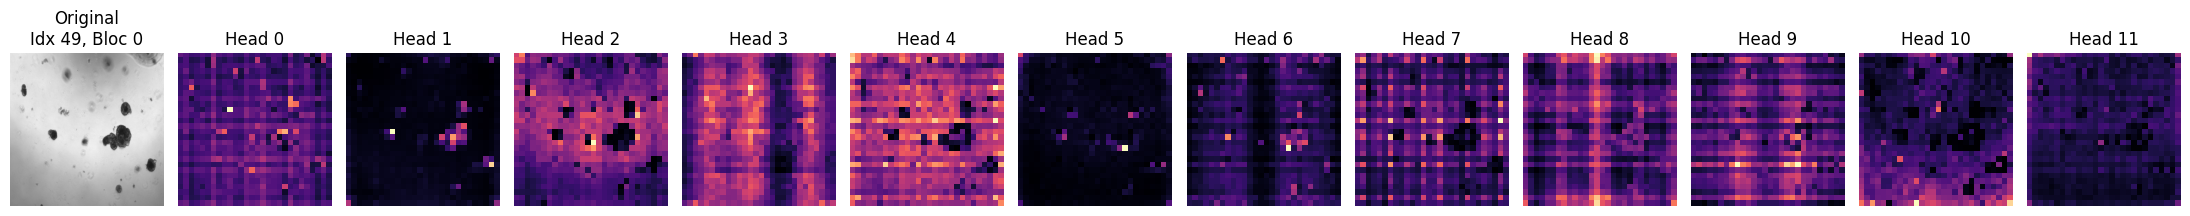

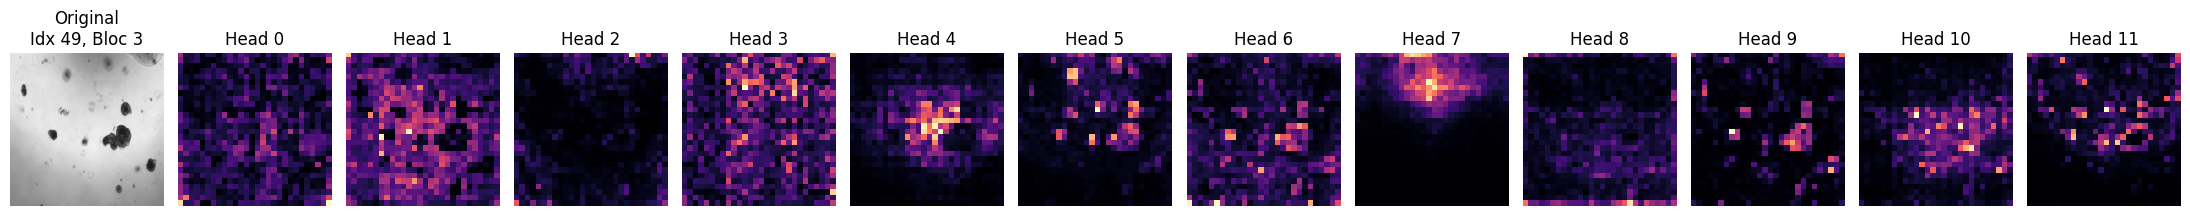

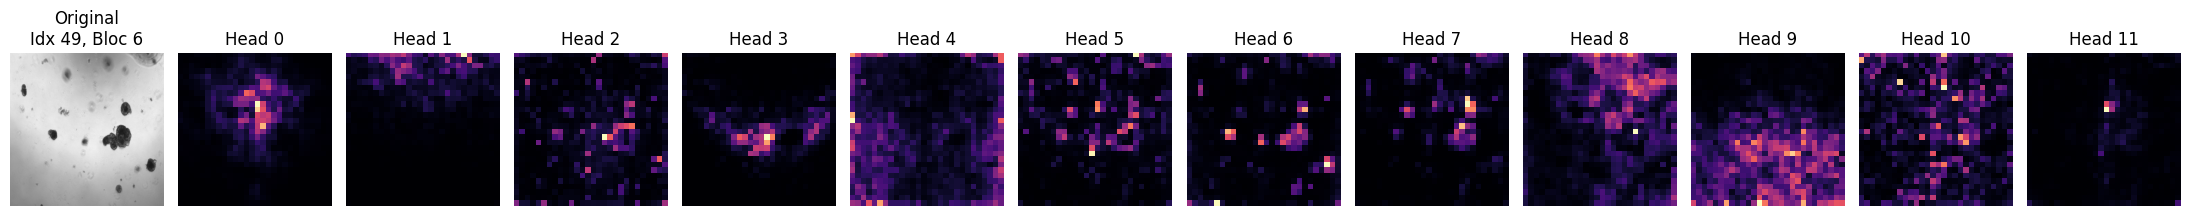

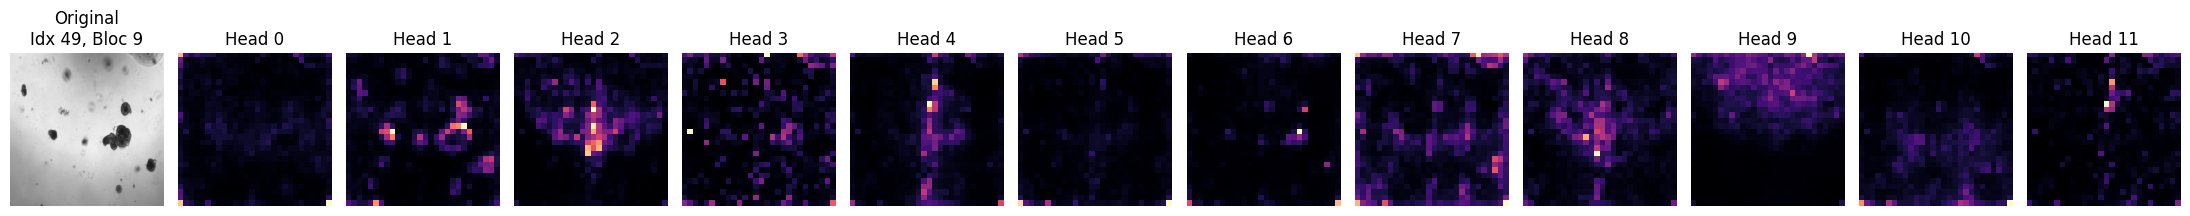

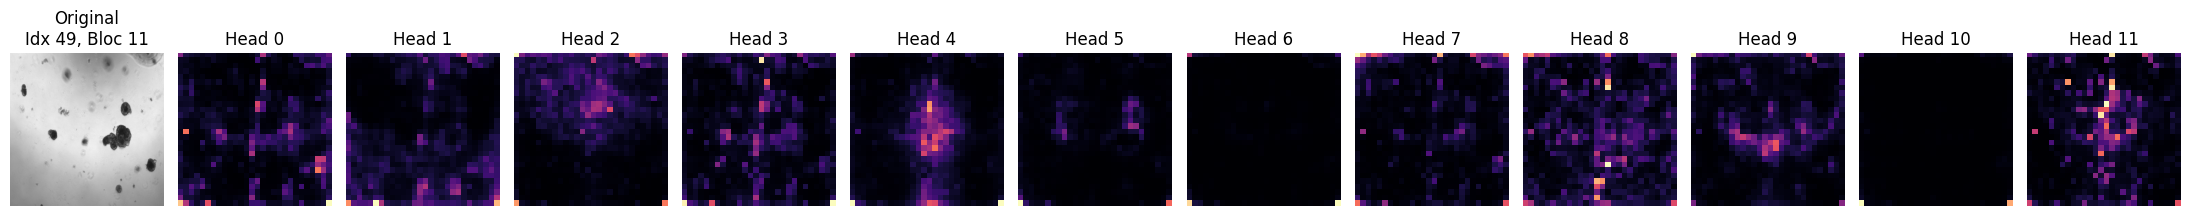

In [30]:
for i in [0, 3, 6, 9, 11]:
    get_attention_maps_curia(model, transform, img_size, img_index=49, block_index=i, h5_path=TELLU_PATH, device=DEVICE)

## PCA at the Token-level

In [ ]:
def get_pca_maps_curia(model, transform, img_size, img_index=0, block_index=11, bg_threshold=0.3, invert_pc=False, h5_path=None, device='cuda'):
    """Calcule la PCA sur les embeddings Curia avec inférence accélérée."""
    model.to(device)
    model.eval()

    if not os.path.exists(h5_path):
        print(f"Erreur : {h5_path} introuvable.")
        return

    with h5py.File(h5_path, 'r') as hdf:
        img_raw = np.array(hdf['train']['images'][list(hdf['train']['images'].keys())[img_index]])
    
    # Curia : 1 canal
    img_pil = Image.fromarray(img_raw).convert('L')
    img_display = img_pil.convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Inférence ultra-rapide
    with torch.inference_mode():
        # On passe par les embeddings
        x = model.embeddings(img_tensor)
        
        # Passage dans l'encodeur jusqu'au bloc index + 1 
        # (car on veut la sortie APRES le bloc spécifié)
        for i in range(block_index + 1):
            x = model.encoder.layer[i](x)[0]
    
    # 1. Extraire les embeddings des patches (sans CLS token à l'index 0)
    # Shape attendue : [784, 768] pour une grille 28x28
    patch_embeddings = x[0, 1:].cpu().numpy()
    
    # 2. PCA (Analyse en Composantes Principales)
    # La PCA permet de réduire la dimension 768 en 3 composantes (RGB)
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(patch_embeddings)

    # 3. Grille de patches (Curia : 448/16 = 28)
    total_patches = pca_features.shape[0]
    grid_size = int(math.sqrt(total_patches))
    
    # 4. Normalisation
    rgb_channels = []
    for i in range(3):
        pc = pca_features[:, i]
        pc_min, pc_max = pc.min(), pc.max()
        pc_norm = (pc - pc_min) / (pc_max - pc_min + 1e-8)
        if i == 0 and invert_pc: # Inversion optionnelle sur PC1
            pc_norm = 1.0 - pc_norm
        rgb_channels.append(pc_norm)
    
    # 5. Création image RGB et Masquage
    rgb_flat = np.stack(rgb_channels, axis=-1)
    mask = rgb_channels[0] > bg_threshold # Utilise PC1 comme masque de segmentation
    rgb_flat = rgb_flat * mask[:, np.newaxis]
    
    pca_maps = rgb_flat.reshape(grid_size, grid_size, 3)
    
    # --- Visualisation ---
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes[0].imshow(img_display.resize((img_size, img_size)))
    axes[0].set_title(f"Original\nBloc {block_index}")
    axes[0].axis('off')
    
    titles = ["PC1 (R)", "PC2 (G)", "PC3 (B)"]
    for i in range(3):
        map_pc = rgb_channels[i].reshape(grid_size, grid_size)
        axes[i+1].imshow(map_pc, cmap='gray')
        axes[i+1].set_title(f"{titles[i]}\n{pca.explained_variance_ratio_[i]*100:.1f}% var")
        axes[i+1].axis('off')
    
    axes[4].imshow(pca_maps, interpolation='nearest')
    axes[4].set_title(f"PCA RGB Combined\nTotal: {pca.explained_variance_ratio_.sum()*100:.1f}%")
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()